In [3]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import trackpy as tp
from scipy import ndimage  # for shifting images
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate
from scipy.optimize import curve_fit

In [4]:
#master dataframe(Unchanged part of the Code)
m_df = []
m_df.append([])
m_df.append([])
#load all the data into the one dataframe
num = 7 #number of trials
trial_offset = 18 #last trial number we are skipping. trial_offset=9 means the first trial we load is #10
for i in range(num):
    m_df[0].append(pd.read_csv("t"+str(i+trial_offset+1)+"c.csv")) #"close" arrays in 0 spot
    m_df[1].append(pd.read_csv("t"+str(i+trial_offset+1)+"f.csv")) #"far" arrays in 1 spot

C:\Users\lobrient\AppData\Local\Temp\ipykernel_15752\63003478.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  m_df[0].append(pd.read_csv("t"+str(i+trial_offset+1)+"c.csv")) #"close" arrays in 0 spot
C:\Users\lobrient\AppData\Local\Temp\ipykernel_15752\63003478.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  m_df[1].append(pd.read_csv("t"+str(i+trial_offset+1)+"f.csv")) #"far" arrays in 1 spot
C:\Users\lobrient\AppData\Local\Temp\ipykernel_15752\63003478.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  m_df[0].append(pd.read_csv("t"+str(i+trial_offset+1)+"c.csv")) #"close" arrays in 0 spot
C:\Users\lobrient\AppData\Local\Temp\ipykernel_15752\63003478.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.

In [5]:
#load timing array
time = np.array(m_df[0][0].loc[1:,"Time"])
size = len(time)
for i in range(size):
    time[i] = float(time[i])
#create master voltage array
m_v_ar = np.zeros((num, 2, 2, 3, size)) #trial, downrange/uprange, close/far, x/y/z, data
#load data into the master array
#switch letter order because x is on B/F, y is on A/E. First list is downrange, second is uprange
col_names = [["Channel B", "Channel A", "Channel C"], ["Channel F", "Channel E", "Channel G"]] 
for trial in range(num):
    for du in range(2): #du is short for downrange/uprange
        for cf in range(2): #cf is short for close/far
            for xyz in range(3):
                m_v_ar[trial,du,cf,xyz,:] = np.array(m_df[cf][trial].loc[1:,col_names[du][xyz]])

In [6]:
#Acceleration integrator
def find_baseline(channel):
    sum = 0
    for i in range(10000):
        sum += channel[i]
    return sum/10000

conv = 1

def integrate_accel(channel, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(Time.size-1):
        dv = 0.5*(conv*(channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def sub_integrate_vel(channel, lower, higher, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(lower, higher):
        dv = 0.5*((channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def differentiate(data, f_p_s):
    dx = np.zeros(data.size)
    for i in range(dx.size-1):
        dx[i] = (data[i+1]-data[i])*f_p_s
    return dx

In [7]:
#Have to convert the voltage array to acceleration. In trials 1-9 the close accelerometers are 16 g while far are 3 g
#3g has .30 Volts/g, 16 g has .057 volts/g

scales = np.array([0.057, 0.3]) #volts/g for 16g (close), 3g (far) accelerometers

#Finding the baseline of each array
voltage_baselines = np.zeros((num, 2, 2, 3)) #trial, downrange/uprange, close/far, x/y/z
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                voltage_baselines[i,j,k,l] = find_baseline(m_v_ar[i,j,k,l,:]) #storing each baseline

#master acceleration array (in m/s/s)
m_ac_ar = np.zeros((num,2,2,3,size))
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                m_ac_ar[i,j,k,l,:] = (m_v_ar[i,j,k,l,:]-voltage_baselines[i,j,k,l])/scales[k]*9.81

In [8]:
#find the integration start index
int_start = np.zeros((num,2,2,3))
threshold = 0.05 #volts
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                int_start[i,j,k,l] = np.argmax((m_v_ar[i,j,k,l,:]-voltage_baselines[i,j,k,l])>threshold)-100

In [9]:
#master velocity array (in m/s)
m_ve_ar = np.zeros((num,2,2,3,size))
velocity_sum=np.zeros((num,3,size))
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                start = int_start[i,j,k,0]
                m_ve_ar[i,j,k,l,:] = sub_integrate_vel(m_ac_ar[i,j,k,l,:],int(start),int(start+1000),time)
                velocity_sum[i,j,:]=np.sum(m_ve_ar[i,:size])

In [10]:
#finding peaks
peak_ac = np.zeros((num,2,2,3))
peak_vel = np.zeros((num,2,2,3))
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                a_ind = np.argmax(m_ac_ar[i,j,k,l,:]**2)
                v_ind = np.argmax(m_ve_ar[i,j,k,l,:]**2)
                peak_ac[i,j,k,l] = m_ac_ar[i,j,k,l,a_ind]
                peak_vel[i,j,k,l] = m_ve_ar[i,j,k,l,v_ind]

In [11]:
#Define positions array for the position of each accelerometer. This only works for the earlier trials due to the pattern in their data
pos = np.zeros((9,3)) #trial number, depth/close_distance/far_distance
#values for trials 10-18. We create a 3 by 6 array for the cylindrical coordinates of each accelerometer. 
depths = [5,7,3]
close_pos = [7,9]
far_pos = [10,12]
for i in range(2):
    for j in range(2):
        pos[i*2+j,0] = depths[i]
        pos[i*2+j,1] = close_pos[j]
        pos[i*2+j,2] = far_pos[j]

In [12]:
# Position array for normal impacts defined here. 
pos = np.zeros(28) 
pos[0:28] = [6,10,7,11,8,12,9,13,6,10,7,11,6,10,7,11,8,12,9,13,6,10,7,11,8,12,9,13]


In [13]:
#absolute value of peak accelerations and velocities calculated here
abs_peak_ac = np.zeros((num,2,2))
abs_peak_vel = np.zeros((num,2,2))
for i in range(num):
    for j in range(2):
        for k in range(2):
            abs_peak_ac[i,j,k] = (peak_ac[i,j,k,0]**2+peak_ac[i,j,k,1]**2+peak_ac[i,j,k,2]**2)**0.5
            abs_peak_vel[i,j,k] = (peak_vel[i,j,k,0]**2+peak_vel[i,j,k,1]**2+peak_vel[i,j,k,2]**2)**0.5

In [14]:
#Acceleration and velocity data saved for easy use in other files here. 
np.save('velocitycomp_10_25', peak_vel)
np.save('accelcomp_10_25', peak_ac)
np.save('velocity_10_25', abs_peak_vel)
np.save('accel_10_25', abs_peak_ac)
np.save('time_10_25', time)

In [15]:
#model for curve fitting defined here
def func(x, A, B):
    y = A*(x**B)
    return y


For 5 cm, The value of A is 100004.00000 with standard error of 4153370.09843.
 and The value of B is -4.00000 with standard error of 3.10417.
for 7 cm, The value of A is 228.18777 with standard error of 235.92097.
and The value of B is -2.01471 with standard error of 0.79237.
For 3cm, The value of A is 1402.10729 with standard error of 2350.83667.
and The value of B is -2.84623 with standard error of 1.35534.


Text(0.5, 0, 'radial (cylindrical) distance from crater center in units of crater radii (2 cm) ')

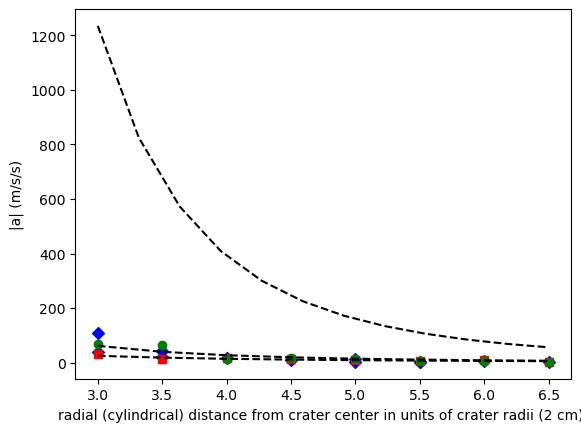

In [16]:
#All three depths plotted here for trials 19-15 with attempted curve fits. 
depths = ["5cm","7cm","3cm"]
cs = [ "ORANGE","BLUE", "RED","GREEN", "GOLD","VIOLET","CYAN"] #colors defined

ydata1=[]
ydata2=[]
ydata3=[]

for i in range(7):#for each trial
    for j in range(2):#for uprange/downrange
        for k in range(2):#for close/far
            if i<=2: 
                plt.scatter(pos[i*2*2+j*2+k]/2,abs_peak_ac[i,j,k], marker='D', c=cs[1])
                ydata1=np.array(np.append(ydata1, abs_peak_ac[i,j,k]))
                xdata1=np.array(np.linspace(6,13,12)/2)


            elif i>2 and i <=4:  
                plt.scatter(pos[i*2*2+j*2+k]/2,abs_peak_ac[i,j,k], marker='s',c=cs[2])
                ydata2=np.array(np.append(ydata2, abs_peak_ac[i,j,k]))
                xdata2=np.array(np.linspace(6,13,8)/2)


            elif i>4 and i <=6:
                plt.scatter(pos[i*2*2+j*2+k]/2,abs_peak_ac[i,j,k], c=cs[3])
                ydata3=np.array(np.append(ydata3, abs_peak_ac[i,j,k]))
                xdata3=np.array(np.linspace(6,13,8)/2)
#Code for curve-ftting is below
parameters1, covariance1 = curve_fit(func, xdata1, ydata1)
fit_A1=100004#parameters1[0]
fit_B1 = -4#parameters1[1]
#print(fit_A1)
#print(fit_B1)
fit_y1 = func(xdata1, fit_A1, fit_B1)
plt.plot(xdata1, fit_y1, 'k', linestyle='dashed',label='Fit')
ydata2=np.array(ydata2)            
parameters2, covariance2 = curve_fit(func, xdata2, ydata2)
fit_A2= parameters2[0]
fit_B2 = parameters2[1]
#print(fit_A2)
#print(fit_B2)
fit_y2 = func(xdata2, fit_A2, fit_B2)
plt.plot(xdata2, fit_y2, 'k', linestyle='dashed',label='Fit')
ydata3=np.array(ydata3)            
parameters3, covariance3 = curve_fit(func, xdata3, ydata3)
fit_A3=parameters3[0]
fit_B3 = parameters3[1]
#print(fit_A3)
#print(fit_B3)
fit_y3 = func(xdata3, fit_A3, fit_B3)
plt.plot(xdata3, fit_y3, 'k', linestyle='dashed',label='Fit')
SE1 = np.sqrt(np.diag(covariance1))# standard errors are calculated here
SE_A1 = SE1[0]
SE_B1 = SE1[1]
SE2 = np.sqrt(np.diag(covariance2))
SE_A2 = SE2[0]
SE_B2 = SE2[1]
SE3 = np.sqrt(np.diag(covariance3))
SE_A3 = SE3[0]
SE_B3 = SE3[1]
print(F'For 5 cm, The value of A is {fit_A1:.5f} with standard error of {SE_A1:.5f}.')
print(F' and The value of B is {fit_B1:.5f} with standard error of {SE_B1:.5f}.')
print(F'for 7 cm, The value of A is {fit_A2:.5f} with standard error of {SE_A2:.5f}.')
print(F'and The value of B is {fit_B2:.5f} with standard error of {SE_B2:.5f}.')
print(F'For 3cm, The value of A is {fit_A3:.5f} with standard error of {SE_A3:.5f}.')
print(F'and The value of B is {fit_B3:.5f} with standard error of {SE_B3:.5f}.')

legend_elements = [plt.Line2D([0], [0], marker='D', color='w', label='Scatter',markerfacecolor='b', markersize=10), 
                   plt.Line2D([0], [0], marker='s', color='w', label='Scatter',markerfacecolor='r', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor='g', markersize=10)]
#custom legend created here for the plot.

#plt.title('Depth of 3 cm. A=1402.107294385178 B=-2.8462262329588603')
#plt.yscale('log') #logarithmic Y-axis
#plt.legend(legend_elements, depths)
plt.ylabel("|a| (m/s/s)")
plt.xlabel("radial (cylindrical) distance from crater center in units of crater radii (2 cm) ")


(0.0, 0.06)

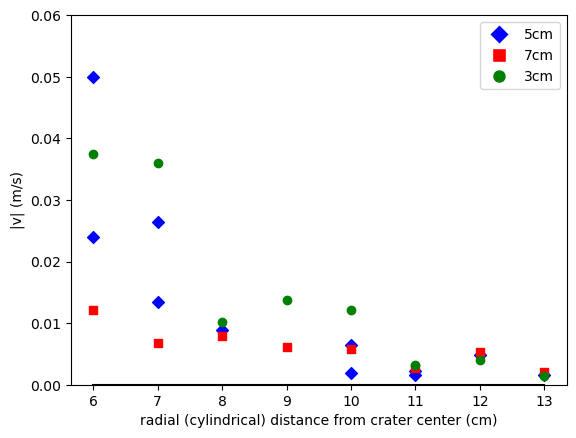

In [17]:
#Essentially this is similar  code but just for velocity instead of acceleration
#cs = [ "ORANGE","BLUE", "RED","GREEN", "GOLD","VIOLET","CYAN"] #depths go 5cm, 7cm, 3cm
depths = ["5cm","7cm","3cm"]
cs = [ "ORANGE","BLUE", "RED","GREEN", "GOLD","VIOLET","CYAN"] #depths go 5cm, 7cm, 3cm
for i in range(7):
    for j in range(2):
        for k in range(2):
            if i<=2: 
                plt.scatter(pos[i*2*2+j*2+k],abs_peak_vel[i,j,k], marker='D', c=cs[1])
            elif i>2 and i <=4:  
                plt.scatter(pos[i*2*2+j*2+k],abs_peak_vel[i,j,k], marker='s',c=cs[2])
            elif i>4 and i <=6:
                plt.scatter(pos[i*2*2+j*2+k],abs_peak_vel[i,j,k], c=cs[3])

legend_elements = [plt.Line2D([0], [0], marker='D', color='w', label='Scatter',markerfacecolor='b', markersize=10), 
                   plt.Line2D([0], [0], marker='s', color='w', label='Scatter',markerfacecolor='r', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor='g', markersize=10)]

plt.legend(legend_elements, depths)
plt.plot([6,13],[0,0],color="BLACK")
plt.ylabel("|v| (m/s)")
plt.xlabel("radial (cylindrical) distance from crater center (cm)")
plt.ylim(0.00,0.06)


In [18]:
m_ac_ar.shape

(7, 2, 2, 3, 200004)

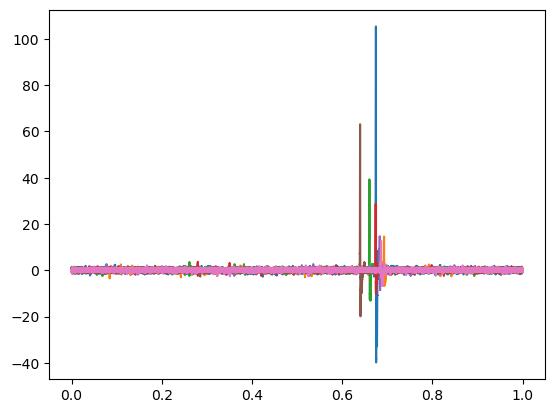

In [19]:
for i in range(num):
    plt.plot(time,m_ac_ar[i,0,0,0,:])#aha this is in gs not in m/s/s

In [20]:
impact_time=np.zeros(6)
impact_time

array([0., 0., 0., 0., 0., 0.])

In [21]:
def onset_time(v):
    m=np.argmax(v)
    ind=m-100
    onset=time[ind]
    return ind, onset
b,a=onset_time(m_ve_ar[0,0,0,0,:])
d,c=onset_time(m_ve_ar[1,0,0,0,:])
f,e=onset_time(m_ve_ar[2,0,0,0,:])
h,g=onset_time(m_ve_ar[3,0,0,0,:])
j,i=onset_time(m_ve_ar[4,0,0,0,:])
l,k=onset_time(m_ve_ar[5,0,0,0,:])
m,n=onset_time(m_ve_ar[6,0,0,0,:])
# Onset times are calculated here for the velocity array. 


In [22]:
d

138545

In [23]:
time1=np.zeros(200004)
time2=np.zeros(200004)
time3=np.zeros(200004)
time4=np.zeros(200004)
time5=np.zeros(200004)
time6=np.zeros(200004)
time7=np.zeros(200004)

for i in range(200004):
        time1[i]=time[i]-a
        time2[i]=time[i]-(691.2839031/1000)
        time3[i]=time[i]-e
        time4[i]=time[i]-(673.0880211/1000)
        time5[i]=time[i]-(681.7071231/1000)
        time6[i]=time[i]-(638.6116131/1000)
        time7[i]=time[i]-(684.5801571/1000)



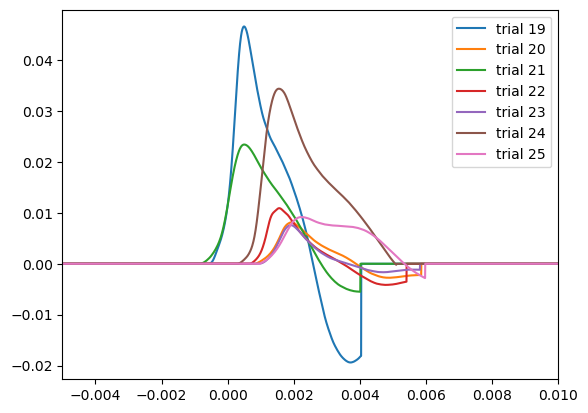

In [24]:
#for i in range(num):
plt.plot(time1,m_ve_ar[0,0,0,0,:], label='trial 19')
plt.plot(time2,m_ve_ar[1,0,0,0,:], label='trial 20')
plt.plot(time3,m_ve_ar[2,0,0,0,:], label='trial 21')
plt.plot(time4,m_ve_ar[3,0,0,0,:], label='trial 22')
plt.plot(time5,m_ve_ar[4,0,0,0,:], label='trial 23')
plt.plot(time6,m_ve_ar[5,0,0,0,:], label='trial 24')
plt.plot(time7,m_ve_ar[6,0,0,0,:], label='trial 25')


#plt.ylim(-0.1,0.1)
plt.xlim(-0.005,0.01)
#plt.xlim(-0.2,0.2)
#plt.ylim(-0.03,0.05)
plt.legend(loc='upper right')